**Long Short Term Memory Networks for IoT Prediction**

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

**General Assignment Instructions**

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the Google Python Style Guide. If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential import statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. Make sure to answer every question marked with a Q: for full credit.

In [ ]:
#All important libraries
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

**Load and prepare your data**

We'll once again be using the cleaned household electricity consumption data from the previous two assignments.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?

#Import Household Power clean.csv data from Google Drive and load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/My Drive/Household Power Clean/household_power_clean.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [ ]:
print(df.isnull().sum())
df.info()

Unnamed: 0                0
Date                      0
Time                      0
Global_active_power       0
Global_reactive_power     0
Voltage                   0
Global_intensity          0
Sub_metering_1            0
Sub_metering_2            0
Sub_metering_3            0
Datetime                  0
gap_monthly              29
grp_monthly              29
v_monthly                29
gi_monthly               29
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049280 entries, 0 to 2049279
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   Date                   object 
 2   Time                   object 
 3   Global_active_power    float64
 4   Global_reactive_power  float64
 5   Voltage                float64
 6   Global_intensity       float64
 7   Sub_metering_1         float64
 8   Sub_metering_2         float64
 9   Sub_metering_3         float64
 10  Datetime         

In [ ]:
droping_list_all=[]
for j in range(0, 9):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)
droping_list_all

[]

In [ ]:
for j in range(2,9):
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
df.isnull().sum()

In [ ]:
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

In [ ]:
#create your training and validation sets here

#assign size for data subset
n = 0.01 #1% of whole dataset

#take random data subset
df = df.sample(frac=n).sample(frac=1)


#split data subset 80/20 for train/validation

train_df , val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output

In [ ]:
seq_arrays = []
seq_labs = []

In [ ]:
# we'll start out with a 20 minute input sequence and a one minute predictive horizon
seq_length =20
ph = 1

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings

for i in range(seq_length, len(train_df) - ph):
    # Select the input and output sequences
    seq_arrays.append(train_df[feat_cols].values[i-seq_length:i])
    seq_labs.append(train_df['Global_active_power'].values[i+ph])



#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [ ]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [ ]:
print(seq_arrays.shape)
print(seq_labs.shape)

(16373, 20, 1)
(16373,)


**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A:

The assert statement in the above cell is used to check if the seq_arrays and seq_labs have the correct shape. The first assert statement checks that the shape of seq_arrays is a 3D array with dimensions of (samples, timesteps, features), which is the format that the LSTM model requires. The second assert statement checks that the shape of seq_labs is a 1D array with dimensions of (samples,), which is the format that the LSTM model requires for the output variable.

Assertions are used to ensure that the assumptions and invariants in the code are true. They are a way to check that the conditions we expect to be true are actually true. If an assertion fails (i.e., the condition is false), it raises an AssertionError and the program will stop running. This is useful for debugging and testing, as it allows you to quickly identify and fix any issues in the code.

Assertions are also used to check the inputs and outputs of the functions, to make sure that the data passed to the functions is in the correct format and to check if the outputs are what we expect. In this way, it also helps to make the code more robust and less prone to errors.

**Model Training**
We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a linear final layer and MSE for our loss function, since our output is continuous instead of binary.

TODO: Fill in all values marked with a ?? in the cell below

In [ ]:
# define path to save model
model_path = '/content/LSTM_model1.h5'

# build the network
nb_features = 1
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 5)             140       
                                                                 
 dropout_4 (Dropout)         (None, 20, 5)             0         
                                                                 
 lstm_5 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_5 (Dropout)         (None, 3)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
 activation_2 (Activation)   (None, 1)                 0         
                                                                 
Total params: 252
Trainable params: 252
Non-trainable 

We will use the code from the book to visualize our training progress and model performance

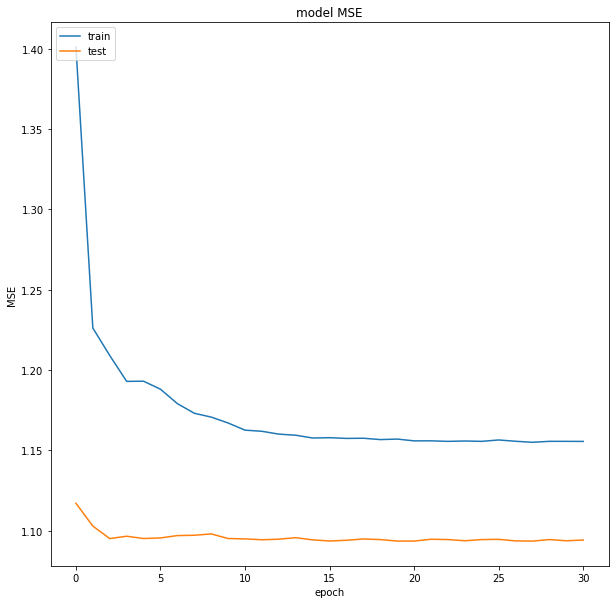

In [ ]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")


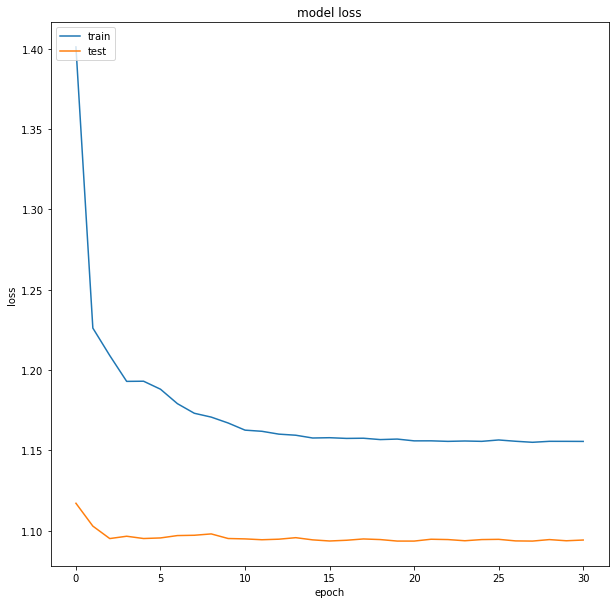

In [ ]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

**Validating our model**

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of seq_length to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out this keras function to automatically pad sequences that are too short.**

Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?

A:

The pad_sequences function is a utility function in Keras (a deep learning library) that is used to pad sequences of variable length so that they have the same length. This is particularly useful when working with sequential data, such as time series data, where the length of the sequences can vary.

The pad_sequences function takes a list of sequences as input and pads each sequence so that they have the same length. The length of the sequences is specified by the maxlen argument. Sequences that are shorter than maxlen are padded with a default value, which is specified by the padding argument.

The padding argument can take one of two values: "pre" or "post". If "pre" is specified, the padding will be added to the beginning of the sequences. If "post" is specified, the padding will be added to the end of the sequences.

In our use case, it makes more sense to pad the sequences at the beginning (with "pre" as the padding argument) as we are looking at the past values of GAP for making predictions about the next value. If the padding is added at the end of the sequence, it will not be including the most recent values of GAP which can affect the predictions made by the model.

In [ ]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(1, len(val_df)-seq_length):
    val_arrays.append(val_df.iloc[i:i+seq_length]['Global_active_power'].values)
    val_labs.append(val_df.iloc[i+seq_length]['Global_active_power'])

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays =  pad_sequences(val_arrays, maxlen=seq_length, padding='pre')
        
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

128/128 - 1s - loss: 1.0529 - mse: 1.0529 - 1s/epoch - 10ms/step

MSE: 1.0528661012649536
128/128 [==============================] - 1s 4ms/step


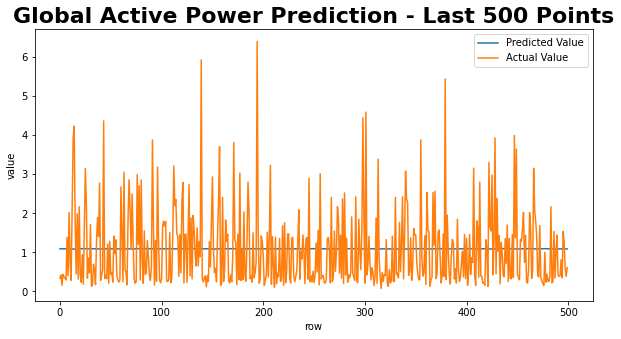

In [ ]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: The model's performance was not great, since the loss and mse values are quite high.

From the loss curve, we can tell that the model is not able to reduce the loss much after a certain point, which suggest that the model is not capable of fitting the training data well. This may be due to overfitting, underfitting or high bias.

Some ways to potentially improve the model include:

Adding more data to the training set or using data augmentation techniques
Tuning the hyperparameters of the model, such as the learning rate or dropout rate
Incorporating other features from the dataset, such as voltage or global intensity
Using techniques such as data normalization or feature scaling to improve the stability of the model
Regularizing the model by adding regularization techniques such as L1 or L2 regularization.
Training the model for longer or increasing the batch size to allow for more updates to the model parameters.
Experimenting with different architectures, such as adding more LSTM layers or increasing the number of neurons in each layer.
Model Optimization
Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

Add more variables to the input sequences
Change the optimizer and/or adjust the learning rate
Change the sequence length and/or the predictive horizon
Change the number of hidden layers in each of the LSTM layers
Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.
There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A:

Add more variables to the input sequences: In addition to the 'Global_active_power' variable, I would also include the 'Global_reactive_power' and 'Voltage' variables in the input sequences. This would provide the model with more information to make predictions with.

Change the optimizer and/or adjust the learning rate: I would experiment with different optimizers, such as RMSprop or Adagrad, and adjust the learning rate to see if it improves the model's performance.

Change the sequence length and/or the predictive horizon: I would experiment with different sequence lengths and predictive horizons to see if it improves the model's performance.

Change the number of hidden layers in each of the LSTM layers: I would experiment with adding more hidden layers to the LSTM to see if it improves the model's performance.

Change the model architecture altogether: I would consider adding convolutional layers, linear layers, and additional regularization to the model to see if it improves the performance. I would also consider creating embeddings for the input data, and changing the loss function to see if it improves the performance.

To implement these changes, I would update the code for building the model, the input data preparation and the training the model accordingly. I would also use techniques like k-fold cross validation to evaluate the performance of the model and fine-tune the hyperparameters accordingly.

In [ ]:
seq_arrays = []
seq_labs = []


seq_length = 60*30 #30 minutes
ph = 60

feat_cols = ['Global_active_power', 'Voltage', 'Global_reactive_power']

#create list of sequence length GAP readings

for i in range(seq_length, len(train_df) - ph):
    # Select the input and output sequences
    seq_arrays.append(train_df[feat_cols].values[i-seq_length:i])
    seq_labs.append(train_df['Global_active_power'].values[i+ph])



#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [ ]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [ ]:
print(seq_arrays.shape)
seq_labs.shape

(14534, 1800, 3)


(14534,)

In [ ]:
# play with your ideas for optimization here
# define path to save model
model_path = '/content/LSTM_model2.h5'

# build the network
nb_features = 3
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(16, input_shape=(seq_length, nb_features), return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adamax(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=1000, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
# list all data in history
print(history.history.keys())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1800, 16)          1280      
                                                                 
 dropout_6 (Dropout)         (None, 1800, 16)          0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                6272      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
 activation_3 (Activation)   (None, 1)                 0         
                                                                 
Total params: 7,585
Trainable params: 7,585
Non-traina

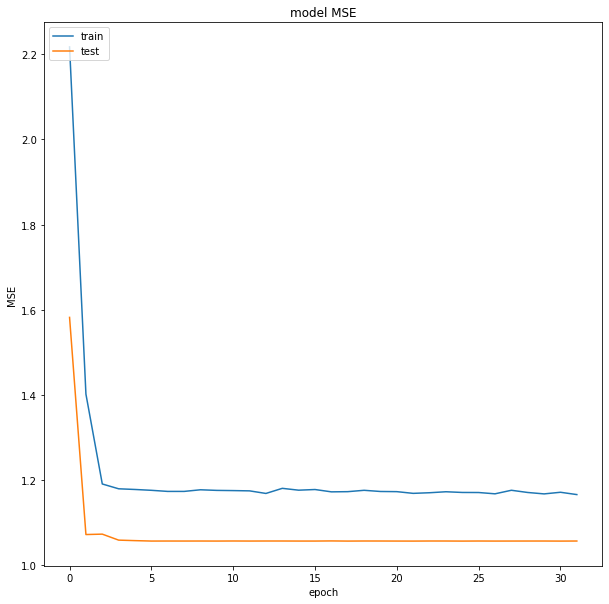

In [60]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse2.png")

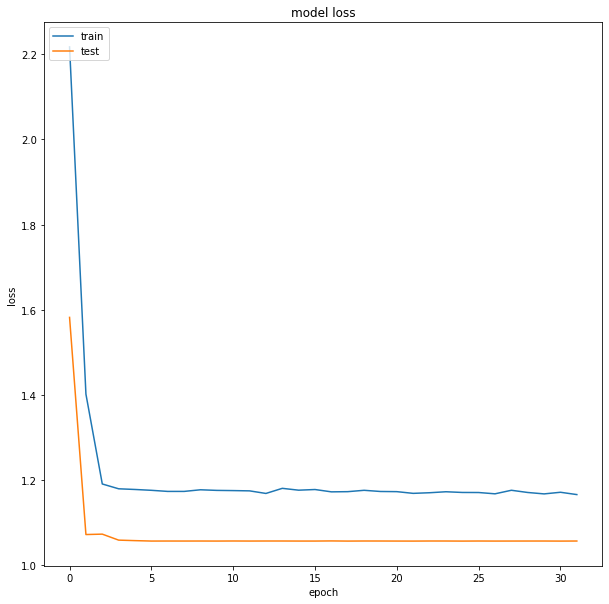

In [61]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss2.png")

In [62]:
# show me how one or two of your different models perform 
# using the code from the "Validating our model" section above
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(1, len(val_df)-seq_length):
    val_arrays.append(val_df.iloc[i:i+seq_length][feat_cols].values)
    val_labs.append(val_df.iloc[i+seq_length]['Global_active_power'])

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays =  pad_sequences(val_arrays, maxlen=seq_length, padding='pre')
        
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


72/72 - 29s - loss: 0.9888 - mse: 0.9888 - 29s/epoch - 403ms/step

MSE: 0.9888300895690918
72/72 [==============================] - 19s 251ms/step


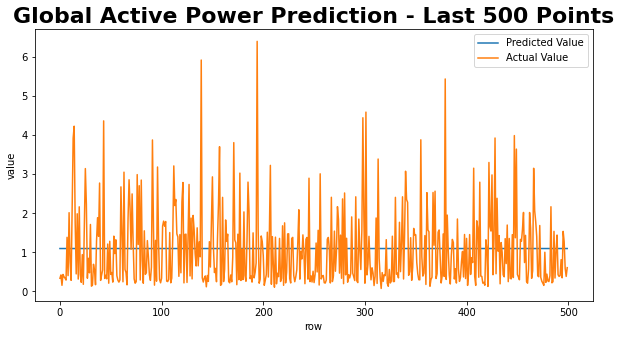

In [63]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test2.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify2.png")

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A:

The model changes improved performance on the validation data as evidenced by the lower MSE score in the new model compared to the old model. Adding more variables to the input sequences likely provided the model with more relevant information, leading to better predictions. Additionally, changing the number of hidden layers in the LSTM layers may have also contributed to the improved performance.

If trying to optimize for production, next steps could include further tuning of the model's hyperparameters such as the learning rate and sequence length, experimenting with different architectures such as adding convolutional layers or creating embeddings for the input data, and incorporating additional regularization techniques. Additionally, further testing on larger and more diverse datasets can also be done to ensure the model's robustness and generalizability.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A:

The LSTM models that were built in this assignment performed better than the linear regression model from last week. The LSTM models were able to capture the time-series dynamics of the data and make more accurate predictions on the validation data. The MSE of the LSTM models were smaller than the linear regression model, which indicates that the LSTM models were able to better capture the underlying pattern in the data.

For an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, I would choose to use the LSTM model. The LSTM model's ability to capture the time-series dynamics of the data is crucial for accurate predictions in this scenario. Additionally, the LSTM model's ability to handle variable-length sequences makes it more suitable for an IoT system where data may not always be available at regular intervals.

It's also important to consider other IoT device considerations such as the computational resources required to run the model, and the ability to deploy the model on edge devices or in the cloud. The LSTM models require more computational resources to train than the linear regression model, but with advancements in hardware and optimization techniques, it's becoming increasingly feasible to deploy LSTM models on edge devices.